In [64]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES
from pyts.classification import TimeSeriesForest

In [65]:
dataset = pd.read_csv('../../datasets/sp_500_stocks/sp500_stocks.csv')

In [66]:
dataset = dataset.dropna()
dataset = dataset.sort_values("Date")
dataset

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
22524,2010-01-04,AMD,9.700000,9.700000,9.900000,9.680000,9.790000,18748700.0
37540,2010-01-04,APD,53.128727,76.928772,77.021278,75.587418,75.957443,1131483.0
1152478,2010-01-04,MKC,13.617592,18.150000,18.205000,18.030001,18.205000,980000.0
255272,2010-01-04,BKNG,222.359650,223.960007,225.300003,221.580002,222.320007,863200.0
469250,2010-01-04,CPRT,2.275625,2.275625,2.308750,2.271875,2.295625,4688000.0
...,...,...,...,...,...,...,...,...
874681,2024-12-02,HLT,250.470001,250.470001,254.335007,249.606293,253.440002,805471.0
889697,2024-12-02,HRL,32.139999,32.139999,32.480000,31.850000,32.480000,3019392.0
893451,2024-12-02,HST,18.389999,18.389999,18.590000,18.270000,18.490000,4656098.0
814617,2024-12-02,GM,55.040001,55.040001,55.619999,54.689999,55.500000,9200689.0


In [67]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
dataset = dataset.drop(columns=['Adj Close', "Volume", "Close", "Open", "Low", "High"])
dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
dataset['quarter'] = dataset['Date'].dt.quarter
def get_season(month):
    if month in [12, 1, 2]:
        return 0#'winter'
    elif month in [3, 4, 5]:
        return 1#'spring'
    elif month in [6, 7, 8]:
        return 2#'summer'
    else:
        return 3#'autumn'
dataset['season'] = dataset['Month'].apply(get_season)
dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


days_ago = 30

dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
dataset["price_365_days_ago"] = dataset["average_price"].shift(365)

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber", "price_30_days_ago", "price_180_days_ago", "price_365_days_ago", "Symbol"]
fieldsPrice = ["average_price"]


dataset = dataset.dropna().reset_index(drop=True)

dataset

,Date,Symbol,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber,price_30_days_ago,price_180_days_ago,price_365_days_ago
0,2010-01-06,EQT,733778,24.610778,2,1,2010,6,1,0,0,1,0,3,17.880000,26.055607,9.790000
1,2010-01-06,STLD,733778,18.910000,2,1,2010,6,1,0,0,1,0,3,10.295000,5.485000,76.304348
2,2010-01-06,IFF,733778,41.740000,2,1,2010,6,1,0,0,1,0,3,109.395000,15.954999,18.117500
3,2010-01-06,LLY,733778,35.385000,2,1,2010,6,1,0,0,1,0,3,6.659500,29.880000,223.440002
4,2010-01-06,EFX,733778,31.620000,2,1,2010,6,1,0,0,1,0,3,22.180000,24.600000,2.290312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581218,2024-12-02,HLT,739222,251.970650,0,12,2024,337,49,0,0,4,0,5447,271.625000,166.625000,34.469999
581219,2024-12-02,HRL,739222,32.165000,0,12,2024,337,49,0,0,4,0,5447,81.692497,63.709999,72.077499
581220,2024-12-02,HST,739222,18.430000,0,12,2024,337,49,0,0,4,0,5447,287.290009,230.209999,137.385002
581221,2024-12-02,GM,739222,55.154999,0,12,2024,337,49,0,0,4,0,5447,596.087494,145.105003,160.824997


In [68]:
dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]

In [69]:
def warn(*args, **kwargs):
    pass
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.warn = warn

In [70]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [71]:
def getRandomBlock(dataset0, blockDayRange):
    max_date = pd.to_datetime(dataset0['Date'].max())
    min_valid_date = max_date - pd.DateOffset(years=1)  # Fecha máxima menos un año
    
    valid_dates = dataset0[dataset0['Date'] <= min_valid_date]['Date']
    if valid_dates.empty:
        raise ValueError("No hay fechas válidas en el rango permitido.")
    
    random_start_date = np.random.choice(valid_dates)
    end_date = random_start_date + pd.DateOffset(days=blockDayRange)
    
    filtered_df = dataset0[(dataset0['Date'] >= random_start_date) & (dataset0['Date'] <= end_date)]
    return filtered_df

In [72]:
def getRandomTrainTestData(dataset0, daysRange, trainDays):
    blockDf = getRandomBlock(dataset0, daysRange)
    min_date = pd.to_datetime(dataset0['Date'].min())
    train_max_day = min_date + pd.DateOffset(days=trainDays)
    trainSamples = dataset0[dataset0['Date'] < train_max_day].shape[0]
    testSamples = len(dataset0.index) - trainSamples

    aux = dataset0.copy()
    aux = aux.drop("Date", axis=1)
    X = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y = aux.copy()

    X_train = X.iloc[:trainSamples]
    Y_train = Y.iloc[:trainSamples]
    X_test = X.iloc[-testSamples:]
    Y_test = Y.iloc[-testSamples:]

    return X_train, Y_train, X_test, Y_test

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

basicRFPrecision = []
for i in range(50):
    X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, 730, 365)
    basicRF = RandomForestRegressor(n_jobs=5, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    y_pred = basicRF.predict(X_test0)
    rmse0 = sqrt(mean_squared_error(Y_test0, y_pred))
    print(f"RMSE:")
    print(rmse0)
    basicRFPrecision.append(rmse0)

RMSE:
205.69245643948702
RMSE:
205.79660881580241
RMSE:
205.6826658447005
RMSE:
205.59042673099475
RMSE:
205.6528762052535
RMSE:
205.79370850622826
RMSE:
205.66727262378882
RMSE:
205.6593218894434
RMSE:
205.79761003370496
RMSE:
205.79799958367198
RMSE:
205.66652261853858
RMSE:
205.64825616355753
RMSE:
205.70458693542182
RMSE:
205.7465299717005
RMSE:
205.65018875454263
RMSE:
205.59660291058808
RMSE:
205.6123375604697
RMSE:
205.84629366613038
RMSE:
205.5637996118403
RMSE:
205.5394758953168
RMSE:
205.61447417571995
RMSE:
205.82520474097154
RMSE:
205.74884922168155
RMSE:
205.6143455288202
RMSE:
205.73777334629702
RMSE:
205.6662394794992
RMSE:
205.62456389397943
RMSE:
205.68333901535885
RMSE:
205.658987504798
RMSE:
205.68191308011035
RMSE:
205.83046173884594
RMSE:
205.65878564722573
RMSE:
205.69643934025643
RMSE:
205.71377478861282
RMSE:
205.74631026712407
RMSE:
205.65236477325416
RMSE:
205.66902229860375
RMSE:
205.849667616513
RMSE:
205.65432530155405
RMSE:
205.6502315976929
RMSE:
205.6097

In [74]:
daysOfBlocks = 730
daysOfTraining = 365
X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, daysOfBlocks, daysOfTraining)
totalSamplesAprox = X_train0.shape[0]
blockSizes = [totalSamplesAprox / 100, totalSamplesAprox / 50, totalSamplesAprox / 25, totalSamplesAprox / 10, totalSamplesAprox / 5]
for i in range(len(blockSizes)):
    blockSizes[i] = int(blockSizes[i])


In [75]:
def testRftsAndGetRmseByAlgorithm(dataset0, daysOfBlocks0, daysOfTraining0, block_size0, algorithm0):
    X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    rfts = RandomForestForTimeSeriesRegressor(n_jobs=5, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[algorithm0])
    rfts.fit(X_train0, Y_train0)
    y_pred = rfts.predict(X_test0)
    rmse0 = sqrt(mean_squared_error(Y_test0, y_pred))
    return rmse0

In [76]:
precisionNonOverlapping = dict()
for block_size in blockSizes:
    precisionNonOverlapping[block_size] = []
    for k in range(10):
        rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 0)
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionNonOverlapping[block_size].append(rmse0)

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 0)
206.71303364491064


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 1)
206.6802587867162


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 2)
207.05602950434266


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 3)
206.79256270554308


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 4)
206.7227287817589


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 5)
206.7415043219335


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 6)
206.87657999899503


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 7)
207.09171660833826


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 8)
206.654881589755


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 9)
207.00144751630424


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 0)
207.6459240937898


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 1)
208.05140927858653


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 2)
207.92938073530956


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 3)
208.18536251664446


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 4)
207.65355018704196


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 5)
208.00954004662353


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 6)
207.77566088426374


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 7)
207.89673123838963


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 8)
207.68427508262408


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 9)
207.60925746425482


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 0)
208.93824172570896


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 1)
208.9328144517144


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 2)
208.69017072773363


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 3)
208.5837825488637


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 4)
208.7999508624837


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 5)
208.802017155502


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 6)
208.8176829888668


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 7)
208.52098438293294


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 8)
208.88816758194463


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 9)
208.69189923351334


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 0)
209.5847766280071


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 1)
209.04731997091642


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 2)
209.7490558838382


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 3)
209.71213113154425


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 4)
210.04747927821873


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 5)
209.6358661755464


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 6)
209.60941381486367


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 7)
209.79302336872078


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 8)
209.57516344568623


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 9)
209.30744683496184


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 0)
210.20515882152978


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 1)
210.5453557175569


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 2)
209.6549128340293


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 3)
210.46685047919576


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 4)
210.4976979597281


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 5)
210.27789958200046


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 6)
210.24048479714358


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 7)
210.24747536736805


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 8)
210.04712101263857


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 9)
209.73059658415502


In [77]:
def getGraphData(presitionDataArray):
    all_arr = [basicRFPrecision]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in blockSizes:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(r)

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

Text(0, 0.5, 'RMSE')

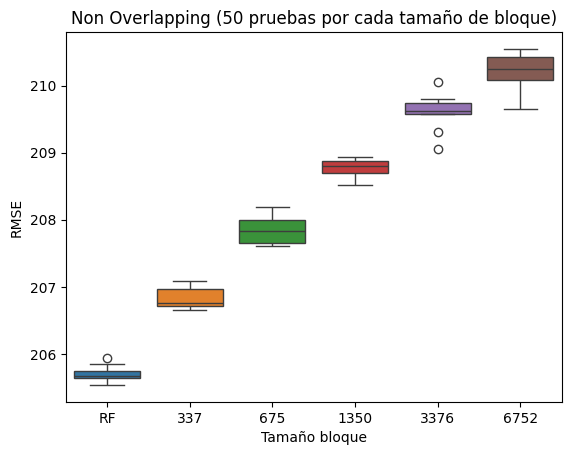

In [78]:
from matplotlib import pyplot as plt

all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Non Overlapping (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque")
plt.ylabel("RMSE")

In [79]:
precisionMovingBlock = dict()
for block_size in blockSizes:
    precisionMovingBlock[block_size] = []
    for k in range(10):
        rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 1)
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionMovingBlock[block_size].append(rmse0)

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 0)
207.1635266696857


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 1)
206.80455059961344


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 2)
206.61998176328402


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 3)
206.868277336414


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 4)
206.84736701343516


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 5)
206.49387152380268


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 6)
207.57199127173374


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 7)
207.29174973604782


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 8)
206.6157405734751


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 9)
206.43036368098538


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 0)
206.81402453621695


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 1)
206.74223966701123


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 2)
206.979715770875


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 3)
206.97315563950443


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 4)
206.76680718035988


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 5)
206.76156761446003


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 6)
207.08589005483077


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 7)
206.9810293638873


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 8)
206.82329357685782


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 9)
207.12720010212533


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 0)
207.13242910491536


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 1)
207.31831726240011


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 2)
206.72343639541793


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 3)
206.82100550601712


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 4)
206.95261246510847


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 5)
206.8100886124742


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 6)
206.55879738143057


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 7)
206.49655219724195


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 8)
206.72381388553626


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 9)
207.08397158801728


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 0)
207.34553568084968


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 1)
206.9847218779511


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 2)
206.76508743835998


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 3)
207.43331620076103


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 4)
207.7600569738699


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 5)
206.79642481456466


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 6)
207.46115721243865


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 7)
207.7056127841871


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 8)
207.5742456200061


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 9)
207.50200787618365


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 0)
207.29694793066423


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 1)
207.26465056982565


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 2)
207.50984945394342


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 3)
207.99105940853175


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 4)
206.8941018739477


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 5)
207.33102224609266


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 6)
207.7963128154195


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 7)
207.9545980189233


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 8)
207.71942722325986


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 9)
207.8809335413868


Text(0, 0.5, 'RMSE')

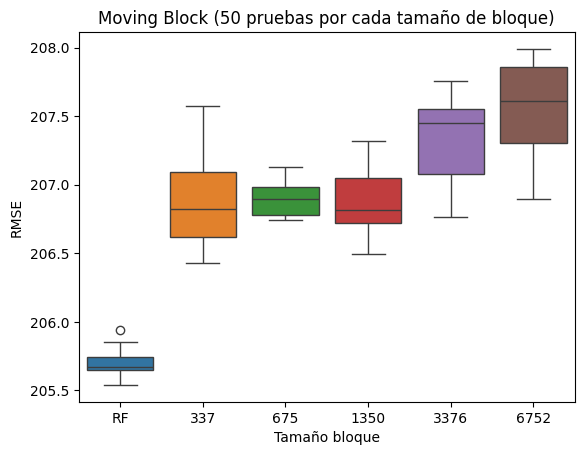

In [80]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Moving Block (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque")
plt.ylabel("RMSE")

In [81]:
precisionCircularBlock = dict()
for block_size in blockSizes:
    precisionCircularBlock[block_size] = []
    for k in range(10):
        rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 2)
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionCircularBlock[block_size].append(rmse0)

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 0)
206.80407819845752


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 1)
207.23622118692566


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 2)
206.87847596138485


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 3)
207.01402279809074


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 4)
206.8609930454597


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 5)
207.09627542268572


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 6)
206.67717125109394


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 7)
206.8955494917222


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 8)
206.87809197663697


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (337, 9)
206.82886552914468


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 0)
206.69847788268564


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 1)
207.16321505600794


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 2)
207.16680731905998


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 3)
207.22746045926516


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 4)
206.8384215297235


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 5)
206.94301256213157


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 6)
206.50559109341836


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 7)
206.6543480407687


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 8)
207.14176374825126


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (675, 9)
207.14210622168935


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 0)
206.901369686998


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 1)
206.8486324194005


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 2)
206.80377910848813


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 3)
206.82237278139377


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 4)
206.82556658483762


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 5)
206.65309737001255


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 6)
206.596033583018


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 7)
207.28182407175774


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 8)
207.2347943692387


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1350, 9)
207.07009352060243


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 0)
207.59955250751494


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 1)
207.26110607682756


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 2)
207.48294546983993


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 3)
207.5278669476896


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 4)
207.04386452120823


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 5)
207.34333067157203


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 6)
206.92069444825853


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 7)
206.92021395046305


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 8)
206.87679771592403


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (3376, 9)
206.9366781509759


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 0)
207.62963116396904


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 1)
207.53985813889486


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 2)
208.0854490017979


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 3)
206.81612695285503


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 4)
207.40016512787594


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 5)
207.80720711724376


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 6)
207.26290413205626


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 7)
206.86776654769326


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 8)
207.65192592820128


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (6752, 9)
207.703393239886


Text(0, 0.5, 'RMSE')

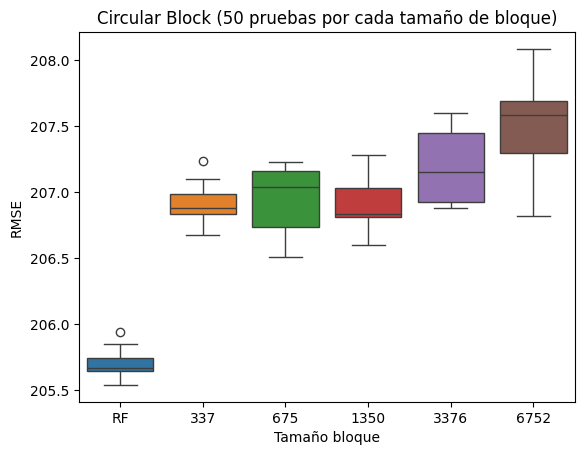

In [82]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Circular Block (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque")
plt.ylabel("RMSE")

Text(38.347222222222214, 0.5, 'RMSE')

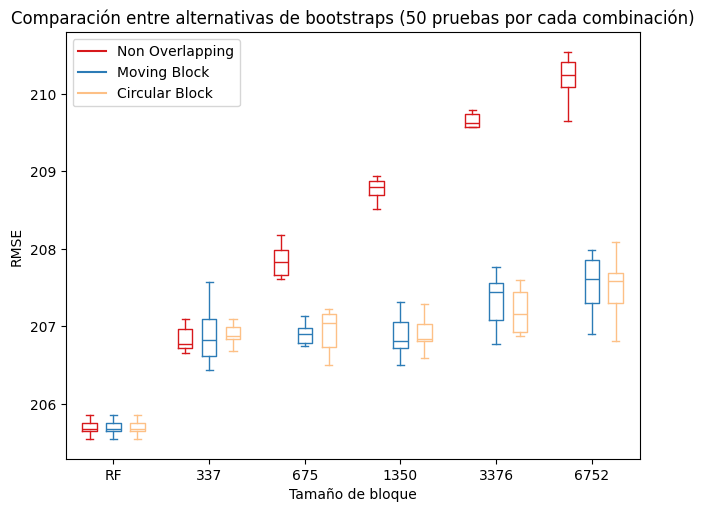

In [83]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)
all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)
all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
# plt.xlim(-2, len(ticks)*2)
#plt.ylim(34, 55)
plt.tight_layout()
plt.title("Comparación entre alternativas de bootstraps (50 pruebas por cada combinación)")
plt.xlabel("Tamaño de bloque")
plt.ylabel("RMSE")